# Binary Classification with CNNs: pneumonia_MNIST Data Set

## Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import datetime

notebook_start_time = datetime.datetime.now()

2025-04-27 12:29:04.710464: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 12:29:04.856749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745771344.920153   11252 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745771344.938233   11252 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745771345.069785   11252 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
test_dir = "data/test"
train_dir = "data/train"
validation_dir = "data/val"

height, width, channels = 150, 150, 1

batch_size = 32

# While working, I discovered that the tf.keras.preprocessing.image.ImageDataGenerator class is deprecated
# using this new API instead

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(height, width),
    batch_size=batch_size,
    label_mode='int',
    color_mode='grayscale',
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(height, width),
    batch_size=batch_size,
    label_mode='int',
    color_mode='grayscale',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(height, width),
    batch_size=batch_size,
    label_mode='int',
    color_mode='grayscale',
)

# because the outputs are batched, we have to concatenate all the batches
y_true = np.concatenate([y for x, y in test_ds], axis=0)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


2025-04-27 12:29:07.329732: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-04-27 12:29:07.799247: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
def summary_graphics(history, model):
    y_pred = np.round(model.predict(test_ds))
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(16, 5)
    ax = ax.flatten()

    # true/false positive/negative rates (better than accuracy for imbalanced data!)
    ax[0].plot(history.history['tp'], label = 'True Positives', color='g')
    #ax[0].plot(history.history['fp'], label = 'False Positives')
    ax[0].plot(history.history['tn'], label = 'True Negatives', color='r')
    #ax[0].plot(history.history['fn'], label = 'False Negatives', color='orange')
    ax[0].grid(True)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Metric Value')
    ax[0].legend(loc='right')
    ax[0].set_title('True Positive and True Negative Rates')

    # loss
    ax[1].plot(history.history['loss'], label='Loss')
    ax[1].plot(history.history['val_loss'], label = 'Val Loss')
    ax[1].grid(True)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(loc='upper right')
    ax[1].set_title('Loss')

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[2])
    ax[2].set_xlabel('Predicted')
    ax[2].set_ylabel('True')
    ax[2].xaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[1][0])/len(y_pred):.3f})', f'Pneumonia ({(cm[0][1] + cm[1][1])/len(y_pred):.3f})'])
    ax[2].yaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[0][1])/len(y_pred):.3f})', f'Pneumonia ({(cm[1][0] + cm[1][1])/len(y_pred):.3f})'])
    ax[2].set_title('Confusion Matrix')

    plt.show()


In [4]:
def get_class_training_weights(assignments, normalize=True):
    # my normal function doesn't work with the tf.data.Dataset object, so I'm writing a new one
    weight_1 = sum(assignments) / len(assignments)
    weight_0 = 1 - weight_1
    if normalize:
        denom = max(weight_1, weight_0)
        weight_1 = weight_1 / denom
        weight_0 = weight_0 / denom
    return {0: weight_0, 1: weight_1}

class_weight = get_class_training_weights(tf.concat([y for x, y in train_ds], axis=0))

print(f"Weight for normal class: {class_weight[0]:1.3f}")
print(f"Weight for pneumonia class: {class_weight[1]:1.3f}")

2025-04-27 12:29:15.564293: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Weight for normal class: 0.346
Weight for pneumonia class: 1.000


## Training

In [7]:
epochs = 10
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((150, 150, 1), name="input"),
    tf.keras.layers.Resizing(28, 28, name="resizing"),
    tf.keras.layers.Flatten(name="5.1flatten"),

    tf.keras.layers.Dense(1000, activation='relu', name="5.2dense"),
    tf.keras.layers.Dense(500, activation='relu', name="5.4dense"),

    tf.keras.layers.Dense(1, activation="sigmoid", name="output")
], name="Model_1")

metrics = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics,
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

model_1.summary()

Model: "Model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.1flatten (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.2dense (Dense)                │ (None, 1000)           │       785,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.4dense (Dense)                │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,286,001 (4.91 MB)

 Trainable params: 1,286,001 (4.91 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model_1.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    class_weight=class_weight,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7998 - loss: 9.2058 - precision: 0.8264 - recall: 0.9215 - tn: 338.9878 - tp: 1868.5061 - val_accuracy: 0.6875 - val_loss: 6.1624 - val_precision: 0.6154 - val_recall: 1.0000 - val_tn: 3.0000 - val_tp: 8.0000
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9016 - loss: 0.7871 - precision: 0.9068 - recall: 0.9685 - tn: 463.8049 - tp: 1916.0305 - val_accuracy: 0.8750 - val_loss: 3.1684 - val_precision: 0.8000 - val_recall: 1.0000 - val_tn: 6.0000 - val_tp: 8.0000
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9152 - loss: 0.5089 - precision: 0.9206 - recall: 0.9702 - tn: 502.6768 - tp: 1921.8170 - val_accuracy: 0.8125 - val_loss: 1.9842 - val_precision: 0.7273 - val_recall: 1.0000 - val_tn: 5.0000 - val_tp: 8.0000
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9261 - loss: 0.5233 - precision: 0.9303 - recall: 0.9753 - tn: 499.6158 - tp: 1930.1403 - val_accuracy: 0

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


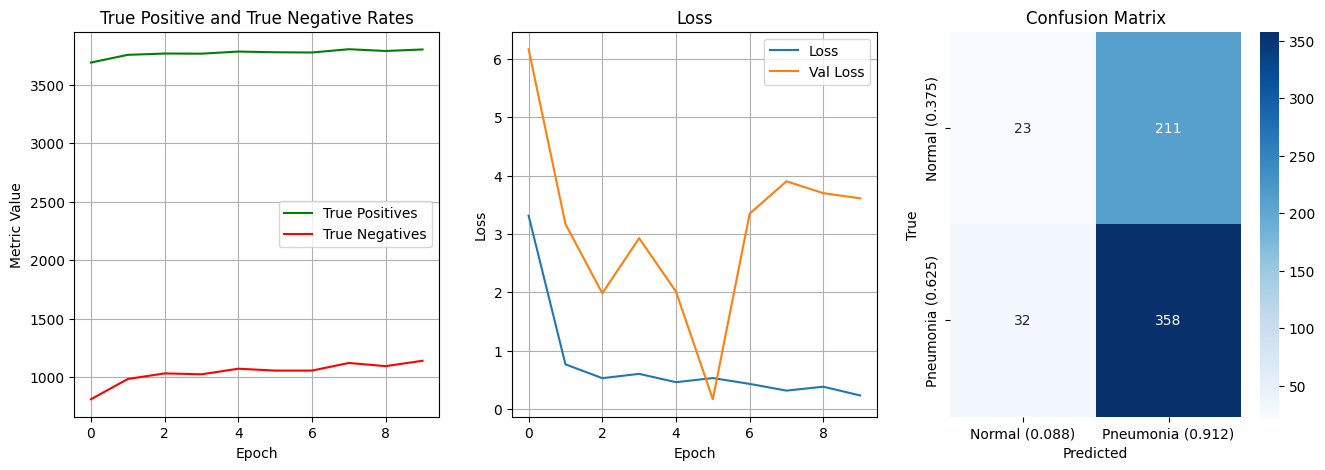

In [9]:
summary_graphics(history, model_1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


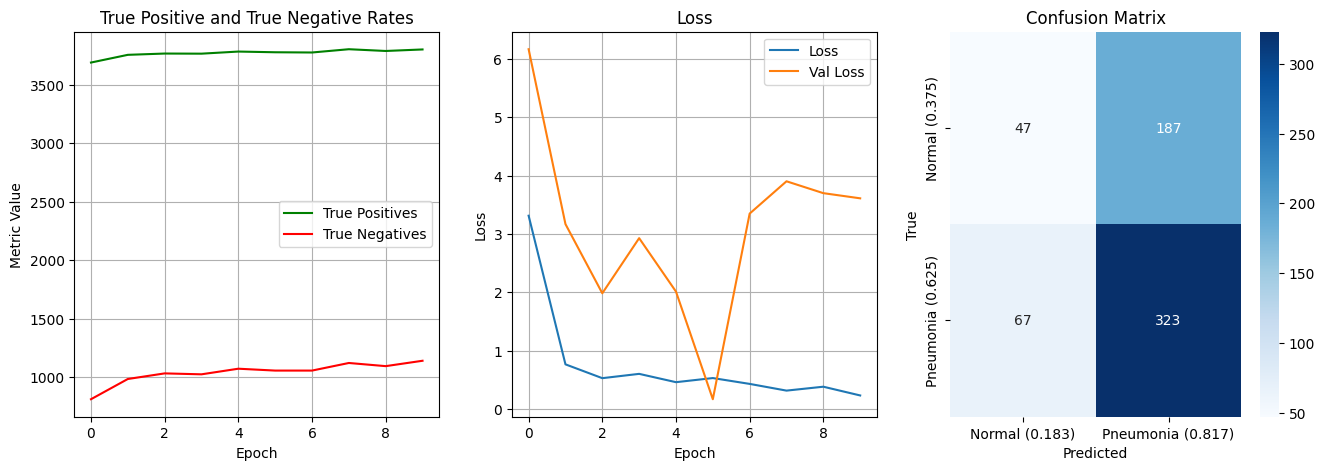

In [10]:
# load the best model
best_model = tf.keras.models.load_model('best_model_resizing_dense.keras')
summary_graphics(history, best_model)

In [11]:
# try something similar to xception, but with fewer filters and layers
# to account for how small these images are
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((150, 150, 1), name="input"),
    tf.keras.layers.Resizing(28, 28, name="resizing"),

    tf.keras.layers.RandomFlip("horizontal", name="0.1rflip"),
    tf.keras.layers.RandomRotation(0.2, name="0.2rrot"),
    tf.keras.layers.RandomTranslation(0.2, 0.2, name="0.3rtran"),
    #tf.keras.layers.RandomZoom(0.2, name="0.4rzoom"),

    tf.keras.layers.Rescaling(1./255, name="rescale"),

    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', name="1.1conv"),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', name="1.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name="1.3pool"),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name="2.1conv"),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name="2.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name="2.3pool"),

    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu', padding='same', name="3.1conv"),
    tf.keras.layers.BatchNormalization(name="3.2batchnorm"),
    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu', padding='same', name="3.3conv"),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name='3.4pool'),

    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu', padding='same', name="4.1conv"),
    tf.keras.layers.BatchNormalization(name="4.2batchnorm"),
    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu', padding='same', name='4.3conv'),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name="4.6pool"),

    tf.keras.layers.Flatten(name="5.1flatten"),

    tf.keras.layers.Dense(512, activation='relu', name="5.2dense"),
    tf.keras.layers.Dropout(0.7, name="5.3dropout"),
    tf.keras.layers.Dense(256, activation='relu', name="5.4dense"),
    tf.keras.layers.Dropout(0.5, name="5.5dropout"),

    tf.keras.layers.Dense(1, activation="sigmoid", name="output")
], name="Model_2")

model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics,
)

model_2.summary()

Model: "Model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 0.1rflip (RandomFlip)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 0.2rrot (RandomRotation)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 0.3rtran (RandomTranslation)    │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescale (Rescaling)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.1conv (Conv2D)                │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.2conv (Conv2D)                │ (None, 28, 28, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.3pool (MaxPooling2D)          │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.1conv (Conv2D)                │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.2conv (Conv2D)                │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.3pool (MaxPooling2D)          │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.1conv (SeparableConv2D)       │ (None, 7, 7, 64)       │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.2batchnorm                    │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.3conv (SeparableConv2D)       │ (None, 7, 7, 64)       │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.4pool (MaxPooling2D)          │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.1conv (SeparableConv2D)       │ (None, 4, 4, 64)       │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.2batchnorm                    │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.3conv (SeparableConv2D)       │ (None, 4, 4, 64)       │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.6pool (MaxPooling2D)          │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.1flatten (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.2dense (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.3dropout (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.4dense (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.5dropout (Dropout)            │ (None, 256)            │             

 Total params: 296,657 (1.13 MB)

 Trainable params: 296,401 (1.13 MB)

 Non-trainable params: 256 (1.00 KB)

In [12]:
history = model_2.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    class_weight=class_weight,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/10


163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7384 - loss: 0.4528 - precision: 0.7548 - recall: 0.9609 - tn: 22.8110 - tp: 1953.6890 - val_accuracy: 0.5000 - val_loss: 0.7095 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7540 - loss: 0.2597 - precision: 0.7540 - recall: 1.0000 - tn: 0.0000e+00 - tp: 1979.2073 - val_accuracy: 0.5000 - val_loss: 0.6934 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7534 - loss: 0.1982 - precision: 0.7530 - recall: 0.9995 - tn: 10.7073 - tp: 1976.4086 - val_accuracy: 0.5000 - val_loss: 0.6593 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7780 - loss: 0.1867 - precision: 0.7747 - recall: 0.9923 - tn: 113.9085 - tp: 1957.1525 - val_accuracy: 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


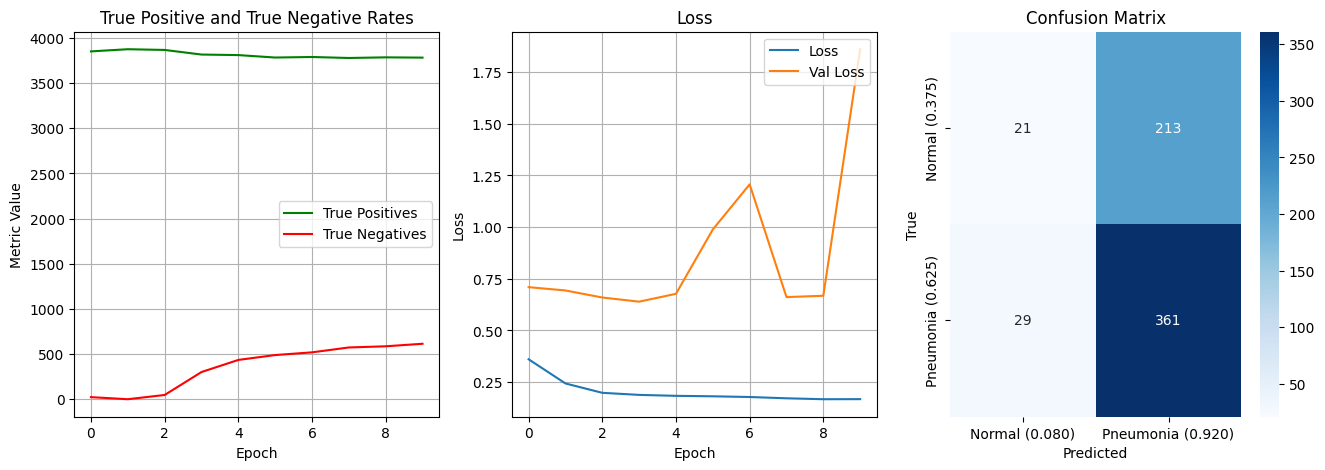

In [13]:
summary_graphics(history, model_2)

In [14]:
# unlike with the MNIST dataset, this model is not overfitting
# let's up the number of neurons
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((150, 150, 1), name="input"),
    tf.keras.layers.Resizing(28, 28, name="resizing"),

    tf.keras.layers.RandomFlip("horizontal", name="0.1rflip"),
    tf.keras.layers.RandomRotation(0.2, name="0.2rrot"),
    tf.keras.layers.RandomTranslation(0.2, 0.2, name="0.3rtran"),
    #tf.keras.layers.RandomZoom(0.2, name="0.4rzoom"),

    tf.keras.layers.Rescaling(1./255, name="rescale"),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name="1.1conv"),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name="1.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name="1.3pool"),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="2.1conv"),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="2.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name="2.3pool"),

    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name="3.1conv"),
    tf.keras.layers.BatchNormalization(name="3.2batchnorm"),
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name="3.3conv"),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name='3.4pool'),

    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="4.1conv"),
    tf.keras.layers.BatchNormalization(name="4.2batchnorm"),
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='4.3conv'),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name="4.6pool"),

    tf.keras.layers.Flatten(name="5.1flatten"),

    tf.keras.layers.Dense(512, activation='relu', name="5.2dense"),
    tf.keras.layers.Dropout(0.5, name="5.3dropout"),
    tf.keras.layers.Dense(256, activation='relu', name="5.4dense"),
    tf.keras.layers.Dropout(0.4, name="5.5dropout"),

    tf.keras.layers.Dense(1, activation="sigmoid", name="output")
], name="Model_3")

model_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics,
)

In [15]:
history = model_3.fit(
    train_ds,
    validation_data=validation_ds,
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weight,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 116ms/step - accuracy: 0.7425 - loss: 0.4265 - precision: 0.7485 - recall: 0.9867 - tn: 4.0000 - tp: 1975.6586 - val_accuracy: 0.5000 - val_loss: 0.7304 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.7543 - loss: 0.2221 - precision: 0.7541 - recall: 0.9995 - tn: 10.5854 - tp: 1975.8903 - val_accuracy: 0.5000 - val_loss: 0.6915 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.8043 - loss: 0.1813 - precision: 0.7988 - recall: 0.9893 - tn: 187.4024 - tp: 1950.7073 - val_accuracy: 0.6875 - val_loss: 0.6381 - val_precision: 0.6667 - val_recall: 0.7500 - val_tn: 5.0000 - val_tp: 6.0000
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.8210 - loss: 0.1819 - precision: 0.8195 - recall: 0.9759 - tn: 260.4817 - tp: 1921.8719 - va

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


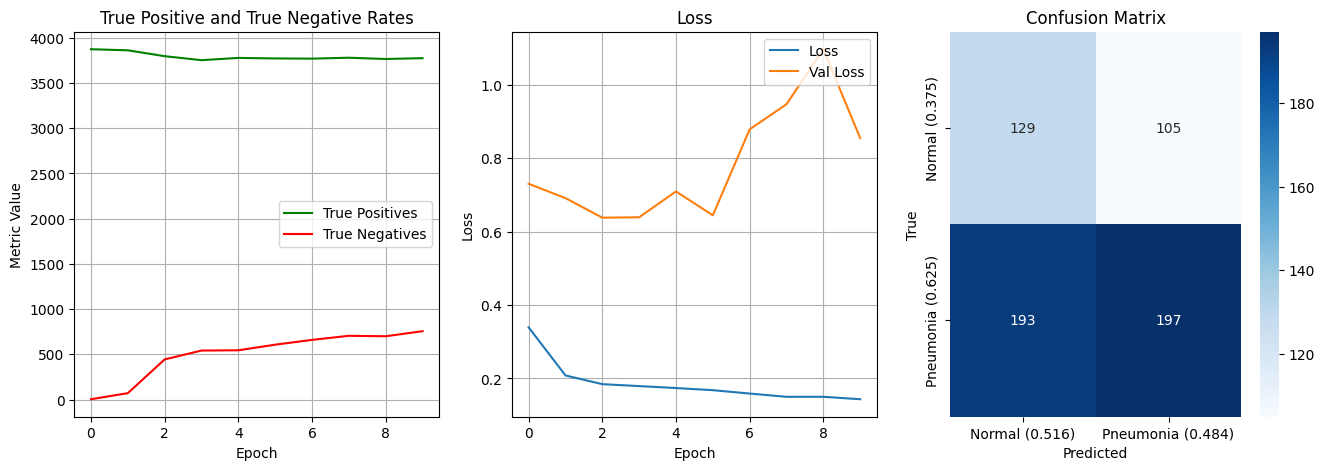

In [16]:
summary_graphics(history, model_3)

In [19]:
# that was pretty rough
# let's increase dropout, add more batch normalization, and add more epochs
epochs = 20
model_4 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((150, 150, 1), name="input"),
    tf.keras.layers.Resizing(28, 28, name="resizing"),

    tf.keras.layers.RandomFlip("horizontal", name="0.1rflip"),
    tf.keras.layers.RandomRotation(0.2, name="0.2rrot"),
    tf.keras.layers.RandomTranslation(0.2, 0.2, name="0.3rtran"),
    #tf.keras.layers.RandomZoom(0.2, name="0.4rzoom"),

    tf.keras.layers.Rescaling(1./255, name="rescale"),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name="1.1conv"),
    tf.keras.layers.BatchNormalization(name="1.2batchnorm"),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name="1.3conv"),
    tf.keras.layers.BatchNormalization(name="1.4batchnorm"),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name="1.3pool"),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="2.1conv"),
    tf.keras.layers.BatchNormalization(name="2.2batchnorm"),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="2.3conv"),
    tf.keras.layers.BatchNormalization(name="2.4batchnorm"),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name="2.5pool"),

    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name="3.1conv"),
    tf.keras.layers.BatchNormalization(name="3.2batchnorm"),
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name="3.3conv"),
    tf.keras.layers.BatchNormalization(name="3.4batchnorm"),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name='3.5pool'),

    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="4.1conv"),
    tf.keras.layers.BatchNormalization(name="4.2batchnorm"),
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='4.3conv'),
    tf.keras.layers.BatchNormalization(name="4.4batchnorm"),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name="4.5pool"),

    tf.keras.layers.Flatten(name="5.1flatten"),

    tf.keras.layers.Dense(512, activation='relu', name="5.2dense"),
    tf.keras.layers.Dropout(0.7, name="5.3dropout"),
    tf.keras.layers.Dense(256, activation='relu', name="5.4dense"),
    tf.keras.layers.Dropout(0.5, name="5.5dropout"),

    tf.keras.layers.Dense(1, activation="sigmoid", name="output")
], name="Model_4")

model_4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics,
)

In [20]:
history = model_4.fit(
    train_ds,
    validation_data=validation_ds,
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weight,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/20


163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - accuracy: 0.7219 - loss: 0.6191 - precision: 0.7666 - recall: 0.9064 - tn: 163.3963 - tp: 2894.5000 - val_accuracy: 0.5000 - val_loss: 0.6933 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 8.0000 - val_tp: 0.0000e+00
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.7661 - loss: 0.2612 - precision: 0.7781 - recall: 0.9628 - tn: 125.3110 - tp: 1904.1647 - val_accuracy: 0.5000 - val_loss: 0.7060 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.7861 - loss: 0.2232 - precision: 0.7958 - recall: 0.9629 - tn: 173.7805 - tp: 1904.8353 - val_accuracy: 0.5000 - val_loss: 1.1487 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.8019 - loss: 0.2059 - precision: 0.8040 - recall: 0.9735 - tn: 196.9085 - tp: 1921.9269 

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


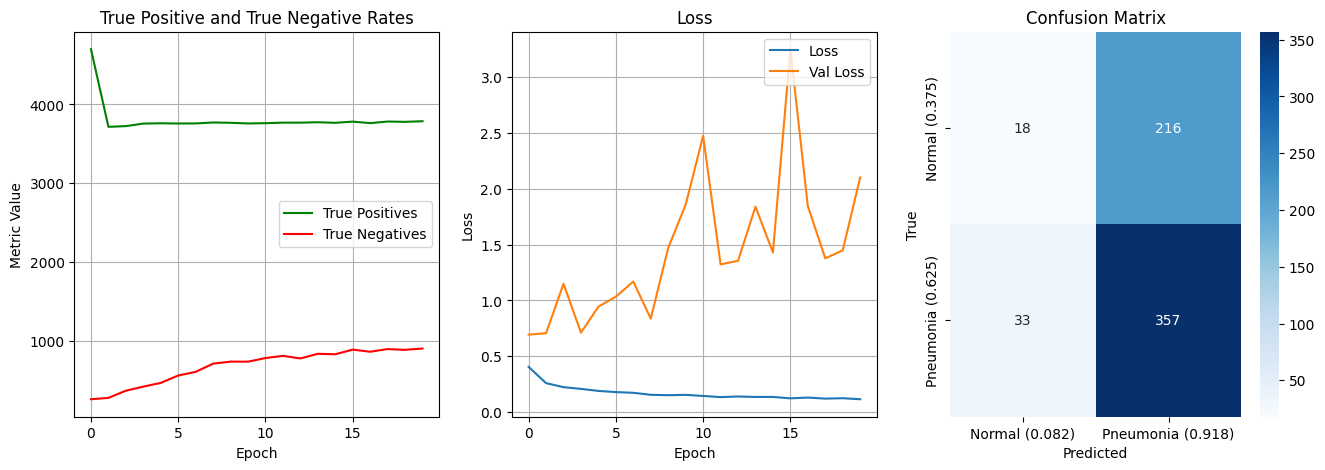

In [23]:
summary_graphics(history, model_4)

In [22]:
# add more convolutional layers and neurons to the dense layers
model_5 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((150, 150, 1), name="input"),
    tf.keras.layers.Resizing(28, 28, name="resizing"),

    tf.keras.layers.RandomFlip("horizontal", name="0.1rflip"),
    tf.keras.layers.RandomRotation(0.2, name="0.2rrot"),
    tf.keras.layers.RandomTranslation(0.2, 0.2, name="0.3rtran"),
    #tf.keras.layers.RandomZoom(0.2, name="0.4rzoom"),

    tf.keras.layers.Rescaling(1./255, name="rescale"),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name="1.1conv"),
    tf.keras.layers.BatchNormalization(name="1.2batchnorm"),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name="1.3conv"),
    tf.keras.layers.BatchNormalization(name="1.4batchnorm"),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name="1.3pool"),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="2.1conv"),
    tf.keras.layers.BatchNormalization(name="2.2batchnorm"),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="2.3conv"),
    tf.keras.layers.BatchNormalization(name="2.4batchnorm"),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name="2.5pool"),

    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name="3.1conv"),
    tf.keras.layers.BatchNormalization(name="3.2batchnorm"),
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name="3.3conv"),
    tf.keras.layers.BatchNormalization(name="3.4batchnorm"),
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name="3.5conv"),
    tf.keras.layers.BatchNormalization(name="3.6batchnorm"),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name='3.7pool'),

    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="4.1conv"),
    tf.keras.layers.BatchNormalization(name="4.2batchnorm"),
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='4.3conv'),
    tf.keras.layers.BatchNormalization(name="4.4batchnorm"),
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='4.5conv'),
    tf.keras.layers.BatchNormalization(name="4.6batchnorm"),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name="4.5pool"),

    tf.keras.layers.Flatten(name="5.1flatten"),

    tf.keras.layers.Dense(1024, activation='relu', name="5.2dense"),
    tf.keras.layers.Dropout(0.7, name="5.3dropout"),
    tf.keras.layers.Dense(512, activation='relu', name="5.4dense"),
    tf.keras.layers.Dropout(0.5, name="5.5dropout"),

    tf.keras.layers.Dense(1, activation="sigmoid", name="output")
], name="Model_5")

model_5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics,
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 159ms/step - accuracy: 0.7276 - loss: 0.3767 - precision: 0.7541 - recall: 0.9414 - tn: 74.0915 - tp: 1887.3842 - val_accuracy: 0.5000 - val_loss: 0.6943 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - accuracy: 0.7815 - loss: 0.2515 - precision: 0.7884 - recall: 0.9693 - tn: 154.5915 - tp: 1915.7561 - val_accuracy: 0.5000 - val_loss: 0.7021 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.8083 - loss: 0.2088 - precision: 0.8098 - recall: 0.9738 - tn: 215.0793 - tp: 1925.5731 - val_accuracy: 0.5000 - val_loss: 0.7513 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 143ms/step - accuracy: 0.8076 - loss: 0.2033 - precision: 0.8137 - recall: 0.9640 - tn: 228.1524 - tp: 1916.457

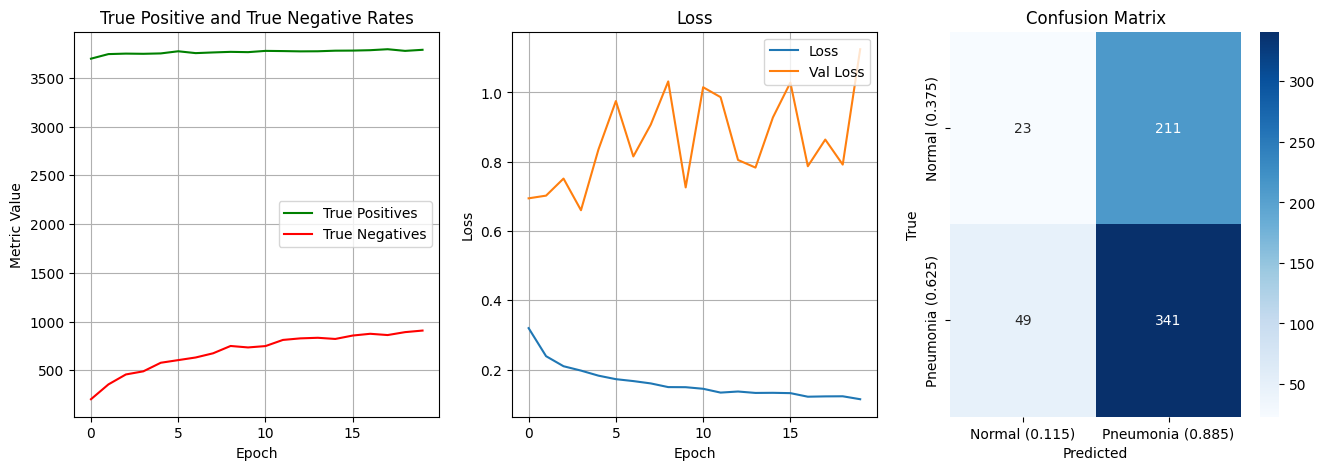

In [24]:
history = model_5.fit(
    train_ds,
    validation_data=validation_ds,
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weight,
    verbose=1,
    callbacks=[checkpoint_callback]
)
summary_graphics(history, model_5)

In [ ]:
notebook_end_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_end_time} (duration: {notebook_end_time - notebook_start_time})")